<div style="display: flex; justify-content: space-between; align-items: center;">
  <span>📅 15/10/2025</span>
    <p align="right">
    <a href="https://colab.research.google.com/github/tripathysagar/NanoTransformer/blob/main/nbs/03_MultiModal.ipynb" target="_blank">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    </p>
</div>

My [Nano GPT](https://tripathysagar.github.io/sagaTrip/gptdecoder.html) model could write Shakespeare-style text. Cool. But it had no idea what a boot looked like. Time to teach it. 

But here's the problem: images and text are fundamentally different beasts. Text? Nice, tidy tokens. Images? Thousands of pixels, each with values from 0-255. The model needs to make sense of *both* simultaneously.

**Aim:** Following the spirit of faster iteration and rapid experimentation, I built a text-to-text model (takes text input, predicts text output). The goal: expand this to handle **multimodal inputs**—learning to generate text captions from images. 

The experiment uses Shakespeare text for language modeling and Fashion-MNIST images with captions for vision-language tasks. This architecture pattern is similar to modern models like LLaVA. The model learns that `👢 → 'simple boot'`

By the end of this blog, you'll see how this approach can be extended to different modalities—audio, medical images, and more.

## Data Preparation
There are two types of data that we have to prepare
1. Text to Text
1. Vison to Text

Before jumping to each type of data. Lets discuss the tokenizer. I used char level tokenizer(detailed discussed in the [Nano-GPT tokenizer](https://tripathysagar.github.io/sagaTrip/gptdecoder.html#tokenization). There are `65` tokens. As we are expanding the learning to new modality there are two new tokens are used 

1. **padding**: fills shot tokens to make uniform length
1. **end of sentence**: to indicates model to stop generation

For the vision-to-text task, apart for its original role `\n` serves two additional roles: marking the end of a caption (so the model knows when to stop generating) and padding shorter captions to uniform length.

### Text to Text

The data for the training is Shakespeare text. The dependent and independent variables are a token list and next tokens. The detailed discussion is done by my [Nano-GPT](https://tripathysagar.github.io/sagaTrip/gptdecoder.html#dataset-preprocessing) blog.


### Vision to Text

For vision, keeping with our ideal of faster iteration, I used the Fashion MNIST dataset, which is for fashion image classification. The dataset consists of grayscale images of size 28×28, and there are 10 types of images. The inputs to the model in the scenario are following:

The input format for vision tasks:
- **Input:** Image (1×28×28 tensor) + text caption tokens  
- **Target:** Next tokens, shifted caption with newline `\n` as **End of Setence** tokens(which model will learn caption and stop generation)

For example, an image of a boot paired with caption tokens for "simple boot" will predict "simple boot\n". This way, the model learns to generate captions autoregressively, just like it generates Shakespeare text.

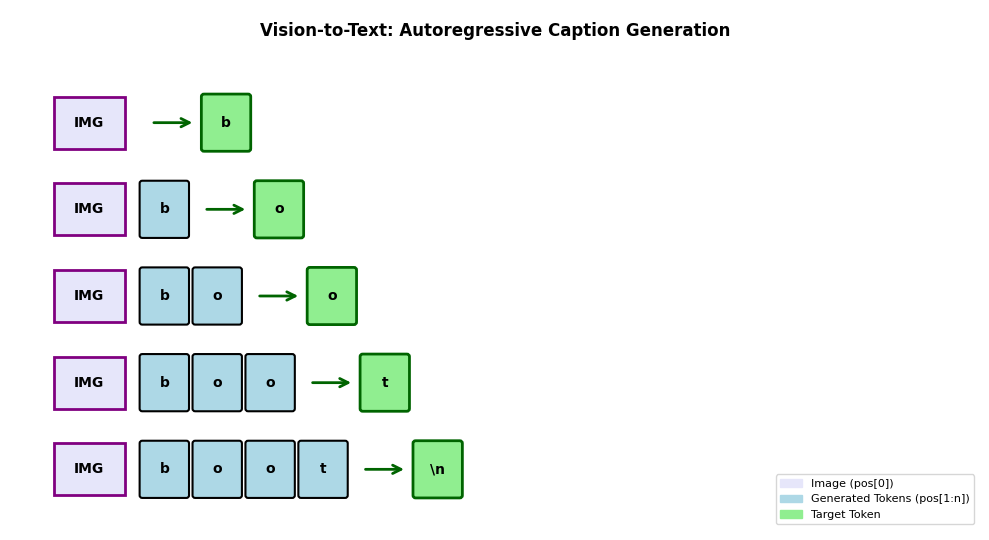

In [ ]:
#|echo: false

import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch, Rectangle
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 5.5))
ax.set_xlim(0, 11)
ax.set_ylim(-0.5, 5.5)

ax.axis('off')

# Title
ax.text(5.5, 5.2, 'Vision-to-Text: Autoregressive Caption Generation', 
        ha='center', fontsize=12, weight='bold')

# Caption tokens
caption = "boot"
tokens = list(caption) + ['\n']  # Add end token

# Draw training examples - need 5 positions for 5 tokens
y_positions = [4.2, 3.2, 2.2, 1.2, 0.2]

for idx in range(len(tokens)):
    y = y_positions[idx]
    x_start = 0.5
    
    # Image box (always present)
    img_box = Rectangle((x_start, y-0.3), 0.8, 0.6, 
                        edgecolor='purple', facecolor='lavender', linewidth=2)
    ax.add_patch(img_box)
    ax.text(x_start + 0.4, y, 'IMG', ha='center', va='center', fontsize=10, weight='bold')
    x_start += 1.0
    
    # Generated tokens so far
    for i in range(idx):
        box = FancyBboxPatch((x_start, y-0.3), 0.5, 0.6,
                            boxstyle="round,pad=0.03",
                            edgecolor='black', facecolor='lightblue', linewidth=1.5)
        ax.add_patch(box)
        token_text = tokens[i] if tokens[i] != '\n' else '\\n'
        ax.text(x_start + 0.25, y, token_text, ha='center', va='center',
               fontsize=10, weight='bold')
        x_start += 0.6
    
    # Arrow
    ax.add_patch(FancyArrowPatch((x_start + 0.1, y), (x_start + 0.6, y),
                                arrowstyle='->', mutation_scale=15,
                                linewidth=2, color='darkgreen'))
    
    # Target token
    target_box = FancyBboxPatch((x_start + 0.7, y-0.3), 0.5, 0.6,
                               boxstyle="round,pad=0.03",
                               edgecolor='darkgreen', facecolor='lightgreen',
                               linewidth=2)
    ax.add_patch(target_box)
    token_text = tokens[idx] if tokens[idx] != '\n' else '\\n'
    ax.text(x_start + 0.95, y, token_text, ha='center', va='center',
           fontsize=10, weight='bold')

# Legend in lower right corner
img_patch = mpatches.Patch(color='lavender', label='Image (pos[0])')
input_patch = mpatches.Patch(color='lightblue', label='Generated Tokens (pos[1:n])')
target_patch = mpatches.Patch(color='lightgreen', label='Target Token')
ax.legend(handles=[img_patch, input_patch, target_patch], 
         loc='lower right', fontsize=8, ncol=1)

plt.tight_layout()
plt.show()


### Dataset Statistics

The model trains on two distinct data sources with different characteristics:

| Dataset | Type | Training Samples | Validation Samples | Batch Size | Training Batches | Validation Batches |
|---------|------|-----------------|-------------------|------------|------------------|-------------------|
| Shakespeare | Text-to-Text | ~1M chars | ~100K chars | 64 | 123 | 14 |
| Fashion-MNIST | Vision-to-Text | 60,000 images | 10,000 images | 512 | 118 | 20 |

The similar number of training batches (123 vs 118). This balancing ensures the model gets roughly equal training opportunities on both modalities—more details on the alternating iterator in the Training section.



**A sample for image, input and target caption**

## Arch

The model have three primary units out of which two system for processing image.

1. **GPT2**: The original arch for decoder block, for text-to-text model
1. **vision encoder**: to encode image to lower dimensions
1. **projection layer**: convert encoded image to required dimension for decoder embeddings



![Final Model](./static/blog6/final_multimodal_model.png)


### GPT2

Transformer decoder model for understanding and generating text. Which takes in tokens embedding with the positional embedding to process further by the model. Both the embedding is of shape 128. The complete example for the same is disscussed in details [Nano-gpt model](https://tripathysagar.github.io/sagaTrip/gptdecoder.html#complete-model). The arch as well as the hyper params are kept same which is used for shakespere model.

**Hyperparameters**

| Parameter | Value | Description |
|-----------|-------|-------------|
| **Batch Size** | 256 | Number of sequences processed in parallel |
| **Sequence Length** | 128 | Context window (max tokens the model can see) |
| **Embedding Dimension** | 128 | Size of token/positional embeddings |
| **Number of Layers** | 4 | Transformer blocks stacked |
| **Number of Heads** | 8 | Attention heads per block |
| **Vocabulary Size** | 65 | Total unique characters in dataset |
| **Dropout** | 0.1 | Dropout probability for regularization |
| **Learning Rate** | 1e-3 | Fixed learning rate for Adam optimizer |
| **Max Gradient Norm** | 1.0 | Gradient clipping threshold |
| **Device** | CUDA/CPU | Automatic GPU detection |
| **Dtype** | bfloat16/float16 | Mixed precision training |

For text all the positional encoding are used. In **text-only mode**, tokens use positions [0:n]. In **multimodal mode**, the image embedding takes position [0], and text tokens shift to positions [1:n]. This ensures the image context is visible to all subsequent tokens through casual attention.



### Vision Encoder: Teaching the Model to "See"

The GPT decoder speaks the language of embeddings—vectors of size 128. But images? They're 28×28 pixels. We need a translator. It's like the encoder speaks "pixel" and the decoder speaks "meaning"—we need a bilingual friend.

**Enter the Vision Encoder:** A ResNet-style CNN that compresses Fashion-MNIST images (1×28×28) down to a 512-dimensional feature vector. Think of it as converting raw pixels into a "semantic summary" the decoder can understand.

**Architecture:**
```
Image (1×28×28)
  ↓ ResBlock: 1→64 channels, 28→14 spatial
  ↓ ResBlock: 64→128 channels, 14→7 spatial  
  ↓ ResBlock: 128→256 channels, 7→4 spatial
  ↓ ResBlock: 256→512 channels, 4→2 spatial
  ↓ AdaptiveAvgPool → (512,)
  ↓ Flatten → (512)
```
The 512-dimensional output, it's a sweet spot(not too large nor too small). Modern vision encoders (like CLIP) use 512-768 dimensions for similar reasons. It's enough to capture "boot with laces" vs "ankle boot" without encoding every pixel's cousin.

**Why ResBlocks?** They use skip connections—adding the input directly to the output. This helps gradients flow during training and lets the network learn both "what changed" and "what stayed the same." Modern arch uses VIT(Vision Transformer) for encoding with same core principle. It have larger compression and efficency of learning. But CNN are smaller and faster to itreation. The encoder learns edges and other other shape present in the image. The final layer known as classification head which takes in the embedding and predicts the object. It is dicarded after pretraining only encoder is kept.

**Training:** First, I trained this encoder as a standalone classifier (with a 512→1024→10 classification head) on Fashion-MNIST. After 15 epochs: **98.9% accuracy**.

**Then I froze it.** Think of it like hiring a pre-trained photographer. They already know how to "see" fashion items—we're just teaching the writer (decoder) how to describe their photos. The encoder's weights stay fixed, which decreases computational cost (no gradients for the encoder block). We just need to project those 512-dim features to the decoder's input.
If we update the weight of the vision encoder during final training during the captioning, might leads to catastrophic forgetting.



![The Vison Encoder](./static/blog6/vision_encoder.png.png)

Where each **ResBlock** invoked from

```py
class ResBlock(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2):
        """
        Args:
            ni: number of input channels
            nf: number of output channels (filters)
            ks: kernel size (default 3)
            stride: stride for first conv (default 2 for downsampling)
        """
        super().__init__()
        # First conv: changes channels and spatial dims
        self.conv1 = nn.Sequential(
            nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride),
            nn.BatchNorm2d(nf))

        # Second conv: keeps channels and spatial dims constant
        self.conv2 = nn.Sequential(
            nn.Conv2d(nf, nf, ks, padding=ks//2, stride=1),
            nn.BatchNorm2d(nf))

        # Handle dimension mismatch
        self.skip = nn.Conv2d(ni, nf, 1, stride=stride) if ni != nf else nn.Identity()

    def forward(self, x):
        # Add skip connection to output of two convs
        return F.relu(self.skip(x) + self.conv2(F.relu(self.conv1(x))))
```

### Projection layer

It acts as a bridge for vision encoder and the GPT2's embedding layer. It projects the input of shape 512 to embedding of dim 128, uses a simple linear layer.

### Final Model
The final model as follows. The forward pass logic is slightly changed to accomodate the image.
- When image is present: image → encoder → projection → add pos[0] → concat with text embeddings. 
    1. Token at pos[1] can see: [image]
    1. Token at pos[2] can see: [image, token₁]
    1. Token at pos[3] can see: [image, token₁, token₂]
    1. And so on...

    The generated tokens should have the reference to the image. 
- When Text is only present: just text embeddings. Complete tokens are passed.

```py
class MultiModal(nn.Module):
    def __init__(self):
        super().__init__()

        self.vis_encoder = classifier[0]
        self.proj_layer = nn.Linear(visConfig.head_op_dim, gptConfig.embedding_dim)

        self.embed = Embedding(gptConfig)
        self.blocks = nn.ModuleList(
            [
                nn.Sequential(MultiHeadAttention(gptConfig), FFN(gptConfig))
                for _ in range(gptConfig.n_layers)
            ])
        self.layer_norm = nn.LayerNorm(gptConfig.embedding_dim)
        self.lm_head = nn.Linear(gptConfig.embedding_dim, gptConfig.vocab_size)

        for param in self.vis_encoder.parameters():
            param.requires_grad = False

    def forward(self, text_idx, image=None):
        if image is not None:
            # Ensure image has the correct dtype before passing to the encoder
            image = image.to(self.proj_layer.weight.dtype)                     # ensure the image input has the correct data type
            img_emb = self.proj_layer(self.vis_encoder(image)).unsqueeze(1)    # (bs, 1, 128)
            img_emb = img_emb + self.embed.pos_embed(self.embed.pos_ids[0:1])  # fetch embeddings at the 0th idx
            text_emb = self.embed(text_idx, start_idx=1)                       # positions start at 1
            x = torch.cat([img_emb, text_emb], dim=1)
        else:
            x = self.embed(text_idx)

        for block in self.blocks:
            x = block(x)
        return self.lm_head(self.layer_norm(x))
```

## Training

The loss function is used same as `Nano-GPT` i.e. `CrossEntropyLoss`.
The combined training loss (averaged across both tasks) decreases from 1.66 to 0.78 after 30 epochs. However, tracking each task separately reveals very different learning dynamics.
As the number of batches for vison and text are close to each other this gives the model to equal chance to learn. The training uses a custom TrainBatchIter that alternates between Shakespeare text batches and Fashion-MNIST vision batches (text→vision→text→vision...). This ensures the model gets equal exposure to both modalities throughout training. Which gives the model equal chance to learn. The dataloders can be mixed but it would further complecate the forward pass of the `MultiModal`. 

The model shows interesting behavior across the two tasks. Starting from similar initial losses (Text: 4.43 | Vision: 4.48), the vision-to-text task converges dramatically faster. After 30 epochs, vision loss drops to 0.17 (97% reduction) while text loss reaches 1.44 (68% reduction). This makes sense: captioning 10 Fashion-MNIST classes with short phrases is simpler than mastering Shakespeare's vocabulary and style. The pretrained vision encoder (already 98.9% accurate) does most of the heavy lifting—the model just learns to translate those visual features into words.

Other Hyperparameters remains same Nano-GPT.

## Inference

### Image Inference

The function takes in image and stops generation till the `\n` is generated.
```py
@torch.no_grad()
def generate_caption(image, max_len=30):
    model.eval()
    image = image.unsqueeze(0).to(multiConfig.device).to(multiConfig.dtype)  # Add batch dimension and move to device with correct dtype

    generated = []
    text_idx = torch.empty((1, 0), dtype=torch.long, device=multiConfig.device)  # Empty text

    for _ in range(max_len):
        logits = model(text_idx, image)
        next_token = logits[:, -1, :].argmax(dim=-1)

        # Check for stop token '\n'
        if tokenizer.decode([next_token.item()]) == '\n':
            break

        generated.append(next_token.item())
        text_idx = torch.cat([text_idx, next_token.unsqueeze(0)], dim=1)

    return tokenizer.decode(generated)
```


![Inferenece](./static/blog6/vison_inferenece.png)

The model predicts caption `casual sweater` where as the original caption is `knit sweater`. It all belongs to same class so the classification is working properly.

### Text Generation

The model able to learn Shakespeare text. Below is the text generated. The logic remains same as [generation function](https://tripathysagar.github.io/sagaTrip/gptdecoder.html#generation-inference) in Nano GPT.
```text
To be or not to beast.
And gave me resolved them and lips to hear.
This hath prevent so you and thou, I were, good their
Frozing in a curse; and acchive of a blous,
Whose as hear me, thank, over with wind fair,
And against the pave of him.
'Duke his wrongly souls, holy, and
```



## Conclusion

A quick recap: I built a multimodal model that absorbs both text and image caption data. Although the vision encoder uses CNNs—a relatively old architecture compared to the Vision Transformers (ViT) used in recent LLMs—the core principles remain the same.

**The "Aha" Moments:**

The biggest surprise? **How fast learning happens with the right setup.** The vision task converged in just a few epochs (loss: 4.48 → 0.17), while text took longer (4.43 → 1.44). Three factors made this possible:

1. **Effective batching** - Alternating text/vision batches gave equal learning opportunities
2. **Smart preprocessing** - Pre-training the vision encoder separately, then freezing it
3. **Synthetic data** - Fashion-MNIST with generated captions is small enough to iterate quickly, yet rich enough to learn multimodal alignment

**From Papers to Practice:**

Multimodal papers can feel daunting—billions of parameters, massive datasets, distributed training. But here's the truth: **the principles scale down beautifully.** By starting with Fashion-MNIST (60K images) and Shakespeare the model convergences faster. 

This is the power of first principles. LLaVA uses CLIP + LLaMA. I used ResNet + GPT. Different scale, same idea: freeze a vision encoder, project to language space, let the decoder learn to describe what it sees.

**What's Next?**

- **Upgrade the vision encoder** - Replace ResNet with ViT (once I learn it!)
- **More modalities** - Audio, medical images, time-series data
- **Larger datasets** - COCO captions

The architecture is ready. The principles are proven. Now it's just a matter of scale.